In [12]:
d = 30
D = 120
r = 3
m_1 = 0
X =10^9
PARA = 100

In [14]:
PRIME_TABLE_SIZE = 10^8
K.<a> = NumberField(x^2 - d)
co_loglog = float((2^(r-1) - 1)/2 + m_1)
H = K.class_number()
h = K.narrow_class_group().order()
narrow = 0
if (H != h):
    narrow = 1

In [3]:
import struct
import urllib.request
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
@parallel(PARA)
def plot_points_create(prime_table_segment):
    
    plot_points = []
    
    prime_table_name = 'prime_' + str(prime_table_segment)
    prime_table_target_url = "https://s3ds.mdx.jp/prime_tables/" + prime_table_name
    prime_table_obj = urllib.request.urlopen(prime_table_target_url)
    prime_binary = prime_table_obj.read()  
    table_size = len(prime_binary)/8
    
    prime_tmp = 0
    
    for i in range(0,table_size):
        prime = int.from_bytes(prime_binary[8*i:8*i+8], byteorder='big')  

        if prime_table_segment == 0:
             if (prime - prime_tmp)  > (10^(len(str(prime)) - 2)) :
                plot_points.append(prime)
                prime_tmp = prime
        else:
            if (prime - prime_tmp)  > (10^(len(str(prime)) - 3)) :
                plot_points.append(prime)
                prime_tmp = prime
                
        if i == (table_size -1):
            plot_points.append(prime)
    
    return plot_points

In [5]:
plot_points = list(plot_points_create(list(range(0,X/PRIME_TABLE_SIZE))))
plot_points.sort()

In [6]:
@parallel(PARA)
def list_create(prime_table_segment):
    
    global plot__points, narrow
    
    points = plot_points[prime_table_segment][1]
    
    plot_list = []

    weighted_sum = 0.0
    weighted_sum_spl = 0.0
    weighted_sum_pri = 0.0
    weighted_sum_r_p = 0.0
    weighted_sum_ramified = 0.0

    
    n = 0
    
    prime_table_name = 'prime_' + str(prime_table_segment)
    prime_table_target_url = "https://s3ds.mdx.jp/prime_tables/" + prime_table_name
    prime_table_obj = urllib.request.urlopen(prime_table_target_url)
    prime_binary = prime_table_obj.read()  
    table_size = len(prime_binary)/8
    


    for i in range(0,table_size):
        prime = int.from_bytes(prime_binary[8*i:8*i+8], byteorder='big')    
        
        I = K.ideal(prime)
        F = I.factor()
        len_F = len(F)
        ramified = F[0][1]
        norm = F[0][0].absolute_norm()
        
        weighted_sum = weighted_sum + ramified*float(len_F*(1/sqrt(norm)))

        if (len_F > 1) & (ramified ==1) :
            weighted_sum_spl = weighted_sum_spl + float(len_F*(1/sqrt(norm)))
            if F[0][0].is_principal():
                if narrow == 0:
                    weighted_sum_pri = weighted_sum_pri + ramified*float(len_F*(1/sqrt(norm)))
                else:
                    conj_list = F[0][0].gens_reduced()[0].galois_conjugates(K)
                    if (conj_list[0]*conj_list[1] > 0):
                        weighted_sum_pri = weighted_sum_pri + ramified*float(len_F*(1/sqrt(norm)))
            if norm >= points[n]:
                plot_list.append([norm, weighted_sum, weighted_sum_spl, weighted_sum_pri, weighted_sum_r_p,weighted_sum_ramified ])
                n = n + 1
        if (len_F == 1) & (ramified > 1) :
            weighted_sum_ramified = weighted_sum_ramified + ramified*float(len_F*(1/sqrt(norm)))
        if (len_F == 1) & (ramified ==1) & (prime <= X):
            weighted_sum_r_p = weighted_sum_r_p + float(len_F*(1/sqrt(norm)))
    if norm <= X:
        plot_list.append([norm, weighted_sum, weighted_sum_spl, weighted_sum_pri, weighted_sum_r_p,weighted_sum_ramified])
    prime_table_obj.close()
    return(plot_list)

In [7]:
plot_list = list(list_create(list(range(0,X/PRIME_TABLE_SIZE))))
plot_list.sort()

In [8]:
offset= [0.0,0.0,0.0,0.0,0.0, 0.0]
for l in range(0,X/PRIME_TABLE_SIZE):
    for m in range(0, len(plot_list[l][1])):
        for n in [1 ,2, 3, 4, 5]:
            plot_list[l][1][m][n] = plot_list[l][1][m][n] + offset[n]
    for n in [1 ,2, 3, 4, 5]:
        offset[n] = plot_list[l][1][m][n]

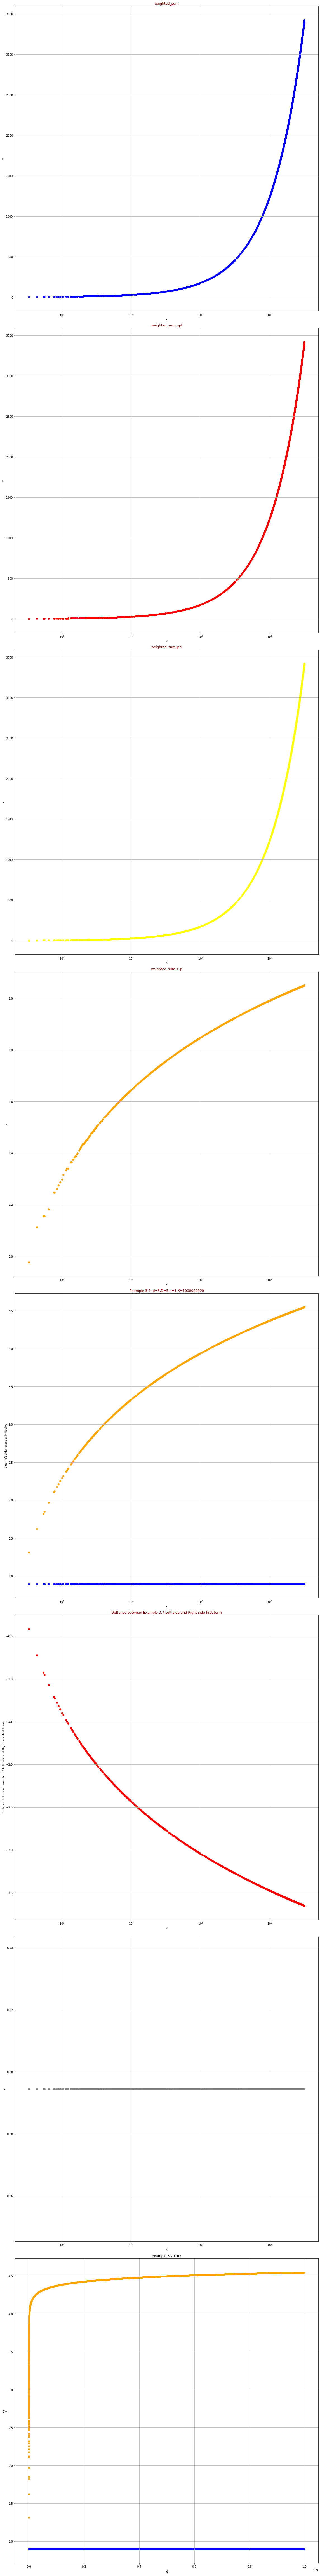

In [11]:
"""
bias against pricipal ideal example 3.7 
"""
import matplotlib.pyplot as plt

fig, ax = plt.subplots(8, 1, tight_layout=True, figsize=(16, 16*8))

plt.xlabel('X',fontsize=18)
plt.ylabel('Y',fontsize=18)
plt.title('example 3.7 D=' + str(D))

for k in range(8):
    ax[k].set_xscale('log')
    ax[k].grid(which="both") # グリッド表示。"both"はxy軸両
    ax[k].set_xlabel("x")
    ax[k].set_ylabel("y")

ax[7].set_xscale('linear')

ylabel_str = "blue: left side, " + "orange: " + str((2^(r-1) - 1)/2 + m_1) +" *loglog"
ax[4].set_ylabel(ylabel_str)
ax[5].set_ylabel("Deffence between Example 3.7 Left side and Right side first term")

ax[0].set_title("weighted_sum", c="darkred", size="large")
ax[1].set_title("weighted_sum_spl", c="darkred", size="large")
ax[2].set_title("weighted_sum_pri", c="darkred", size="large")
ax[3].set_title("weighted_sum_r_p", c="darkred", size="large")
title_str ="Example 3.7: " + "d=" + str(d) + "," + "D=" + str(D) + "," + "h=" + str(h) + "," + "X=" + str(X) 
ax[4].set_title(title_str, c="darkred", size="large")
ax[5].set_title("Deffence between Example 3.7 Left side and Right side first term", c="darkred", size="large")

for i in range(0,X/PRIME_TABLE_SIZE):
    for j in range(0,len(plot_list[i][1])):
        ax[0].scatter(plot_list[i][1][j][0], plot_list[i][1][j][1], color="blue")
        ax[1].scatter(plot_list[i][1][j][0], plot_list[i][1][j][2], color="red")
        ax[2].scatter(plot_list[i][1][j][0], plot_list[i][1][j][3], color="yellow")
        ax[3].scatter(plot_list[i][1][j][0], plot_list[i][1][j][4], color="orange") 
        ax[4].scatter(plot_list[i][1][j][0], plot_list[i][1][j][1] - h*plot_list[i][1][j][3] - h*plot_list[i][1][j][4], color="blue") 
        ax[4].scatter(plot_list[i][1][j][0],  co_loglog*float(log(log(plot_list[i][1][j][0]))), color="orange") 
        ax[5].scatter(plot_list[i][1][j][0], plot_list[i][1][j][1] - h*plot_list[i][1][j][3] - h*plot_list[i][1][j][4] - co_loglog*float(log(log(plot_list[i][1][j][0]))) , color="red")
        ax[6].scatter(plot_list[i][1][j][0], plot_list[i][1][j][5] , color="gray")

        ax[7].scatter(plot_list[i][1][j][0], plot_list[i][1][j][1] - h*plot_list[i][1][j][3] - h*plot_list[i][1][j][4], color="blue") 
        ax[7].scatter(plot_list[i][1][j][0],  co_loglog*float(log(log(plot_list[i][1][j][0]))), color="orange") 
        
bbox = ax[4].get_tightbbox(fig.canvas.get_renderer())
file_name = title_str +'.png'
fig.savefig(file_name,dpi=fig.dpi,bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))
    
plt.show()  